In [1]:
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
#  Copyright 2021-  QuOCS Team
#
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

In [2]:
import matplotlib.pyplot as plt
import os

# Ising model optimization

### The model

We take an Ising model Hamiltonian as our example problem, where *J* and *g* describe the nearest and next-nearest neighbor interaction of an Ising spin chain of *n* qubits. A global control field in the x-direction *u(t)* is used for the control of the system.

$H(t) = - J \sum_{j}^{n} \sigma_j^z \sigma_{j+1}^z \; - g \sum_{j}^{n} \sigma_j^z \sigma_{j+2}^z \; + u(t) \sum_{j}^{n} \sigma_j^x \;$

## GRAPE Optimization

### Define the Model

The user must write a class that is a child of the AbstractFoM class provided by QuOCS to define the problem to be solved. It must contain at least a function called get_FoM which takes the pulses, parameters and times as lists of numpy arrays (or floats for the parameters) and returns a dictionary with the figure of merit (FoM) under the key "FoM". What happens inside the get_FoM function is up to the user. 

In this code one can define *J* and *g* and the number of qubits, as well as the desired initial and target state after evolution of the Hamiltonian under the control field *u(t)*. In get_FoM the pulses are taken to caluclate the evolution under above Hamiltonian and the propagator is applied to the initial state. The resulting final state is overlapped with the target state to extract to state fidelity. This is passed back as a FoM.

In [3]:
import numpy as np
from quocslib.optimalcontrolproblems.su2 import *
from quocslib.utils.AbstractFoM import AbstractFoM
from quocslib.timeevolution.piecewise_integrator import pw_evolution
import functools


class IsingModel(AbstractFoM):
    """
    A figure of merit class for optimization of the problem defined by Alastair Marshall via
    https://arxiv.org/abs/2110.06187
    """
    def __init__(self, args_dict: dict = None):
        if args_dict is None:
            args_dict = {}

        ################################################################################################################
        # Dynamics variables
        ################################################################################################################
        self.n_qubits = args_dict.setdefault("n_qubits", 5)
        self.J = args_dict.setdefault("J", 1)
        self.g = args_dict.setdefault("g", 2)
        self.n_slices = args_dict.setdefault("n_slices", 100)

        self.H_drift = get_static_hamiltonian(self.n_qubits, self.J, self.g)
        self.H_control = get_control_hamiltonian(self.n_qubits)
        self.rho_0 = get_initial_state(self.n_qubits)
        self.rho_target = get_target_state(self.n_qubits)
        self.rho_final = np.zeros_like(self.rho_target)
        # allocate memory for the list containing the propagators
        self.prop_store = [np.zeros_like(self.H_drift) for _ in range(self.n_slices)]
        # Check if the propagators are already computed
        self.propagators_are_computed = False

    def get_control_Hamiltonians(self):
        return self.H_control

    def get_drift_Hamiltonian(self):
        return self.H_drift

    def get_target_state(self):
        return self.rho_target

    def get_initial_state(self):
        return self.rho_0

    def get_propagator(
        self,
        pulses_list: list = [],
        time_grids_list: list = [],
        parameters_list: list = [],
    ) -> np.array:
        """
        Compute and return the list of propagators
        """
        drive = pulses_list[0].reshape(1, len(pulses_list[0]))
        n_slices = self.n_slices
        time_grid = time_grids_list[0]
        # dt = time_grid[1] - time_grid[0]
        dt = time_grid[-1] / len(time_grid)
        # Compute the time evolution
        self.prop_store = pw_evolution(self.prop_store, drive, self.H_drift, [self.H_control], n_slices, dt)
        self.propagators_are_computed = True
        return self.prop_store

    def get_FoM(self, pulses: list = [], parameters: list = [], timegrids: list = []) -> dict:
        """
        Function to calculate the figure of merit from the pulses and parameters and timegrids.
        :param list pulses: List of np.arrays. One np.array for each pulse.
        :param list timegrids: List of np.arrays. One np.array for each time grid.
        :param list parameters: List of floats. One float ofr each parameter.
        :return: dict - The figure of merit in a dictionary
        """
        # Check if the propagator list is computed before compute the final propagator
        if not self.propagators_are_computed:
            self.get_propagator(pulses_list=pulses, time_grids_list=timegrids, parameters_list=parameters)
        self.propagators_are_computed = False
        # Compute the final propagator
        U_final = functools.reduce(lambda a, b: a @ b, self.prop_store)
        # evolve initial state
        rho_final = U_final @ self.rho_0 @ U_final.T.conj()
        # Calculate the fidelity
        fidelity = fidelity_funct(rho_final.T, self.rho_target)
        return {"FoM": fidelity}


### Define the configuration dictionary
This dictionary is passed to the QuOCS optimized in order to tell it what optimization algorithm to use. I also contains further settings for the optimization process.

First, we give the optimization a name, which will also appear in the name of the results folder generated.

In [4]:
optimization_dictionary = {"optimization_client_name": "IsingModelGRAPE"}

#### Settings for the optimization algorithm
The "algotithm_settings" key in gets a dictionary with the name of the algorithm. In this case we use the GRAPE algorithm.

In [5]:
optimization_dictionary["algorithm_settings"] = {"algorithm_name": "GRAPE"}

Now we define some settings for GRAPE: Since we want to maximize the state overlap with the target state, we set the optimization direction to "maximization".

In [6]:
optimization_dictionary["algorithm_settings"]["optimization_direction"] = "maximization"

#### The Controls
The controls are given by a pulse in x-direction. Let's give it some limits, a discretization (100 bins) and an initial variation of the pulse amplitudes. For GRAPE one has to use the piecewise constant basis, so the variation is the change of each value of the amplitude in each time bin. Typically ~30\% of the maximal possible amplitude is a useful starting value. We also connect a time object named "time_1" (defined later) to the pulse to tell it about the duration of the pulse.

In [7]:
pulse_x = {"pulse_name": "Pulse_1",
           "upper_limit": 100.0,
           "lower_limit": -100.0,
           "bins_number": 100,
           "amplitude_variation": 30.0,
           "time_name": "time_1"
           }

### The basis
The "basis" option for GRAPE has to be "PiecewiseBasis".

In [8]:
pulse_x["basis"] = {"basis_name": "PiecewiseBasis"}

#### The times
If there are several pulses on differen timescales, you can define different times here and link them to the pulses accordingly. In our case we have the aforementioned "time_1" which we set to 1.

In [9]:
time1 = {"time_name": "time_1",
         "initial_value": 1.0 }

Now, let's insert the controls in the optimization_dictionary

In [10]:
optimization_dictionary["pulses"] = [pulse_x]
optimization_dictionary["parameters"] = []
optimization_dictionary["times"] = [time1]

### Create the optimizer and run the optimization
All you need to do now is to import the Optimizer from QuOCS and create an optimization object by passing an instance of the FoM object (here IsingModel()) and the optimization_dictionary.

In [11]:
from quocslib.Optimizer import Optimizer
import time

optimization_obj = Optimizer(optimization_dictionary, IsingModel())

INFO     oc_logger    The optimization direction is maximization
INFO     oc_logger    Random number generator from the numpy library, version 1.21.5


To run the optimization, call the .execute() function on the optimization object.

In [12]:
time1 = time.time()
optimization_obj.execute()
time2 = time.time()
print("The optimization took {seconds} seconds".format(seconds=time2 - time1))

INFO     oc_logger    QuOCS version number: 0.0.47
INFO     oc_logger    New record achieved. Previous FoM: -10000000000.0, new best FoM : 0.06355104516676974
INFO     oc_logger    Function evaluation number: 1, FoM: 0.06355104516676974
INFO     oc_logger    New record achieved. Previous FoM: 0.06355104516676974, new best FoM : 0.07466711298244723
INFO     oc_logger    Function evaluation number: 2, FoM: 0.07466711298244723
INFO     oc_logger    New record achieved. Previous FoM: 0.07466711298244723, new best FoM : 0.148042850237688
INFO     oc_logger    Function evaluation number: 3, FoM: 0.148042850237688
INFO     oc_logger    New record achieved. Previous FoM: 0.148042850237688, new best FoM : 0.740694294096147
INFO     oc_logger    Function evaluation number: 4, FoM: 0.740694294096147
INFO     oc_logger    Function evaluation number: 5, FoM: 0.0013251583520040014
INFO     oc_logger    Function evaluation number: 6, FoM: 0.7396625359575397
INFO     oc_logger    New record achieved. 

INFO     oc_logger    Figure of merit : 0.9990581198318891
INFO     oc_logger    nfev : 44
The optimization took 2.9821887016296387 seconds


#### Results
Let us visualize the optimization by looking at the evolution of the FoM over the function evaluations and the final control pulse.

Text(0, 0.5, 'Amplitude')

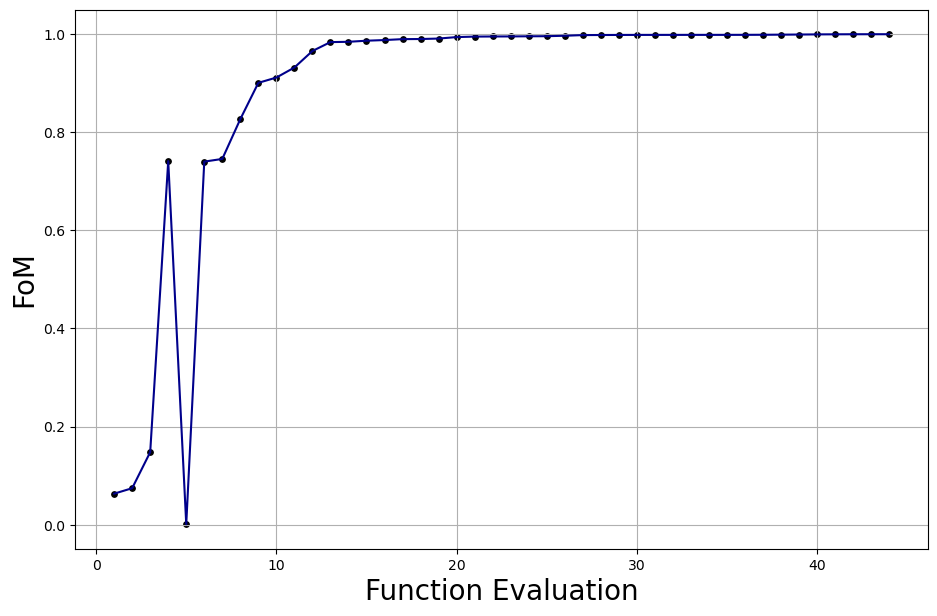

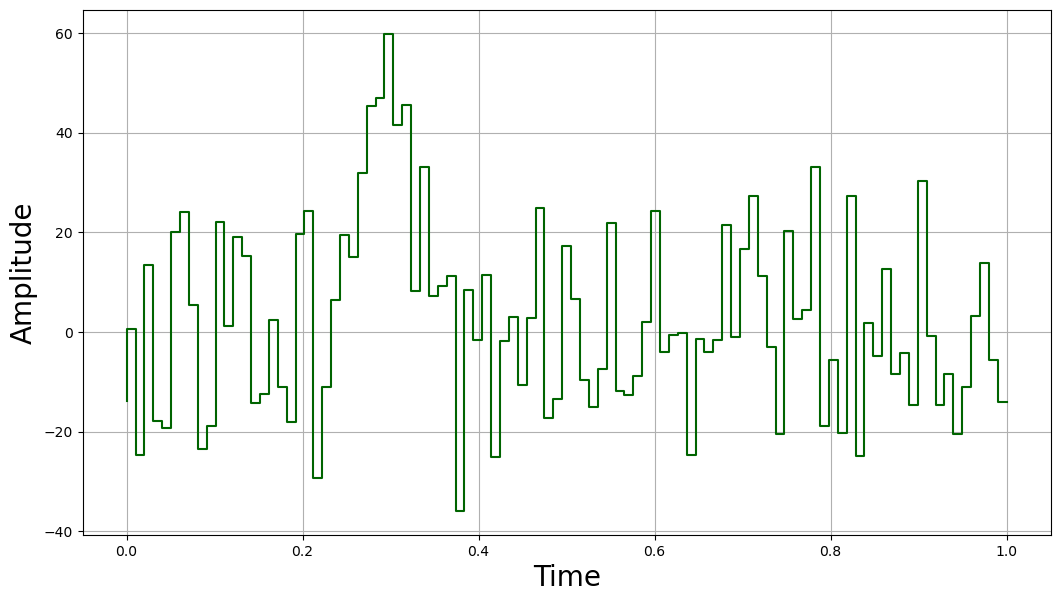

In [13]:
# Get the optimization algorithm object from the optimization object
opt_alg_obj = optimization_obj.get_optimization_algorithm()

# The FoM values for each function evaluation can be founf under FoM_list in the optimization algorithm object
fomlist = opt_alg_obj.FoM_list

# Plot the FoM over the number of evaluations
fig = plt.figure(figsize=(11, 7))
ax = fig.add_subplot(111)
iterations = range(1, len(fomlist)+1)
ax.plot(iterations, np.asarray(fomlist), color='darkblue', linewidth=1.5, zorder=10)
ax.scatter(iterations, np.asarray(fomlist), color='k', s=15)
plt.grid(True, which="both")
plt.xlabel('Function Evaluation', fontsize=20)
plt.ylabel('FoM', fontsize=20)

# The optimized controls can be found via the function get_best_controls() called on 
# the optimization algorithm object
controls = opt_alg_obj.get_best_controls()

# it contains the pulses and time grids under certain keys as a dictionary
pulse, timegrid = controls["pulses"][0], controls["timegrids"][0]

# Plot the pulse over time
fig = plt.figure(figsize=(11, 7))
ax = fig.add_subplot(111)
plt.subplots_adjust(bottom=0.15, top=0.9, right=0.98, left=0.1)
plt.step(timegrid, pulse, color='darkgreen', linewidth=1.5, zorder=10)
plt.grid(True, which="both")
plt.xlabel('Time', fontsize=20)
plt.ylabel('Amplitude', fontsize=20)